<a href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-solution-of-ps-s4e2?scriptVersionId=162325606" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="border: 3px solid yellow; border-radius: 30px; color: white; background-image: url(https://www.kaggle.com/competitions/68479/images/header); padding: 1px 5px 5px 5px">Multi-Class Prediction of Obesity Risk</span>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv
/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv


![](https://www.kaggle.com/competitions/68479/images/header)

# <span style="background-image: url(https://www.kaggle.com/competitions/68479/images/header); color: white; font-size: 50px;">Table of Contents</span>

1. [Import libraries](#1)
2. [Open data files](#2)
3. [Show first 5 lines of train data](#3)
    - 3.1 [Compare original train and competition train](#3.1)
    - 3.2 [Concatenate original train with competition train](#3.2)
4. [Shapes of train and test data](#4)
5. [Display descriptive statistics of train data](#5)
6. [Check the number of gaps for each feature](#6)
7. [Data types of training set](#7)
    - 7.1 [Figure out how much duplicates in data](#7.1)
    - 7.2 [Remove duplicates from data](#7.2)
    - 7.3 [One-hot encoding](#7.3)
8. [Display histograms of distribution](#8)
9. [Let's count target of train data](#9)
10. [Transform the data with logarithm](#10)
    - 10.1 [Pie plot of target](#10.1)
    - 10.2 [Feature importance](#10.2)
11. [Build a heat map of correlations](#11)
12. [Define base models with tuned hyperparameters](#12)
13. [Defining the meta-model with tuned hyperparameters](#13)
14. [Creating and fitting the stacking model](#14)
15. [Predict validation set and calculate accuracy score](#15)
16. [Predict the test data](#16)
17. [Build DataFrame and make submission](#17)

### <p style="color: #3cb371; border-style: solid; border-color: yellow; padding: 5px 5px 5px 5px; border-width: 5px;">The data consist of the estimation of obesity levels in people from the countries of Mexico, Peru and Colombia, with ages between 14 and 61 and diverse eating habits and physical condition , data was collected using a web platform with a survey where anonymous users answered each question, then the information was processed obtaining 17 attributes and 2111 records</p>

### <p style="color: orange; border-style: solid; border-color: yellow; padding: 5px 5px 5px 5px; border-width: 5px;">The attributes related with eating habits are: Frequent consumption of high caloric food (FAVC), Frequency of consumption of vegetables (FCVC), Number of main meals (NCP), Consumption of food between meals (CAEC), Consumption of water daily (CH20), and Consumption of alcohol (CALC). The attributes related with the physical condition are: Calories consumption monitoring (SCC), Physical activity frequency (FAF), Time using technology devices (TUE), Transportation used (MTRANS)</p>

## <span style="color: #3cb371; border-style: solid; padding: 5px 5px 5px 5px; border-width: 5px;">Features:</span>

**Gender**, **Age**, **Height**, **Weight** are physical attributes

**family_history_with_overweight** points out to familiarity with obesity

**FAVC** - Frequent consumption of high caloric food

**FCVC** - Frequency of consumption of vegetables

**NCP** - Number of main meals

**CAEC** - Consumption of food between meals

**SMOKE** - tobacco usage

**CH20** - Consumption of water daily

**SCC** - Calories consumption monitoring

**FAF** - Physical activity frequency

**TUE** - Time using technology devices

**CALC** - Consumption of alcohol

**MTRANS** - Transportation used

![](https://athleanx.com/wp-content/uploads/2023/07/men-bodyfat-percent.jpg)

<a id='1'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc;background-color: #fadb8c;">🏃‍♀️ 1 - Import libraries</span>

In [2]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

<a id='2'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🏃‍♂️ 2 - Open data files</span>

In [3]:
original_train = pd.read_csv('/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')

train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e2/sample_submission.csv')

<a id='3'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🏋️‍♀️ 3 - Show first 5 lines of train data</span>

In [4]:
# Show all properties on display
pd.set_option('display.max_columns', None)

train.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


<a id='3.1'></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">3.1 Compare original train and competition train

In [5]:
print(original_train.shape)
original_train.columns.tolist()

(2111, 17)


['Gender',
 'Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'SMOKE',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'CALC',
 'MTRANS',
 'NObeyesdad']

In [6]:
print(train.shape)
train.columns.tolist()

(20758, 18)


['id',
 'Gender',
 'Age',
 'Height',
 'Weight',
 'family_history_with_overweight',
 'FAVC',
 'FCVC',
 'NCP',
 'CAEC',
 'SMOKE',
 'CH2O',
 'SCC',
 'FAF',
 'TUE',
 'CALC',
 'MTRANS',
 'NObeyesdad']

##### We have to drop 'id' from train and test dataset

In [7]:
submission_id = test.id

train.drop(columns='id', axis=1, inplace=True)
test.drop(columns='id', axis=1, inplace=True)

<a id='3.2'></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">3.2 Concatenate original train with competition train

In [8]:
train = pd.concat(objs=[train, original_train])
train.shape

(22869, 17)

##### Now You can see that train data became +2111 objectives bigger than previous data

<a id='4'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🚶‍♂️ 4 - Shapes of train and test data</span>

In [9]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data consists of {train_data_percentage * 100}% of all observations')
print(f'Test data consists of {(1 - train_data_percentage) * 100}% of all observations')

Train data: (22869, 17)
Test data: (13840, 16)

Train data consists of 62.3% of all observations
Test data consists of 37.7% of all observations


<a id='5'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🍔 5 - Display descriptive statistics of train data</span>

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,22869.0,23.885263,5.753419,14.00,20.000000,22.815416,26.000000,61.00
Height,22869.0,1.700377,0.087881,1.45,1.631662,1.700000,1.763029,1.98
Weight,22869.0,87.767610,26.364243,39.00,66.000000,84.000000,111.531208,173.00
FCVC,22869.0,2.443428,0.533329,1.00,2.000000,2.392665,3.000000,3.00
NCP,22869.0,2.754344,0.712711,1.00,3.000000,3.000000,3.000000,4.00
CH2O,22869.0,2.027442,0.608901,1.00,1.755907,2.000000,2.535127,3.00
FAF,22869.0,0.984382,0.839466,0.00,0.015860,1.000000,1.596576,3.00
TUE,22869.0,0.620551,0.602850,0.00,0.000000,0.579541,1.000000,2.00


In [11]:
contains_inf = train.isin([np.inf, -np.inf]).any().any()
contains_inf

False

##### There is no any inf values

In [12]:
train.describe(include='object').T

,count,unique,top,freq
Gender,22869,2,Female,11465
family_history_with_overweight,22869,2,yes,18740
FAVC,22869,2,yes,20848
CAEC,22869,4,Sometimes,19294
SMOKE,22869,2,no,22580
SCC,22869,2,no,22086
CALC,22869,4,Sometimes,16467
MTRANS,22869,5,Public_Transportation,18267
NObeyesdad,22869,7,Obesity_Type_III,4370


<a id='6'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🥞 6 - Check the number of gaps for each feature</span>

In [13]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(test.isna().sum())

TRAIN data

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64



TEST data

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                    

##### There is no any gaps in values

<a id='7'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🍕 7 - Data types of training set</span>

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22869 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          22869 non-null  object 
 1   Age                             22869 non-null  float64
 2   Height                          22869 non-null  float64
 3   Weight                          22869 non-null  float64
 4   family_history_with_overweight  22869 non-null  object 
 5   FAVC                            22869 non-null  object 
 6   FCVC                            22869 non-null  float64
 7   NCP                             22869 non-null  float64
 8   CAEC                            22869 non-null  object 
 9   SMOKE                           22869 non-null  object 
 10  CH2O                            22869 non-null  float64
 11  SCC                             22869 non-null  object 
 12  FAF                             22869 

##### Therer are 8 features with float values and 9 features which are objects (strings)

### Let's draw pie plot for each categorical features

Gender
Female    11465
Male      11404
Name: count, dtype: int64 




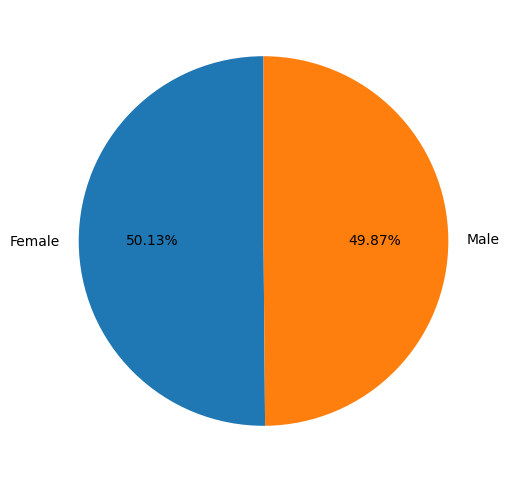

family_history_with_overweight
yes    18740
no      4129
Name: count, dtype: int64 




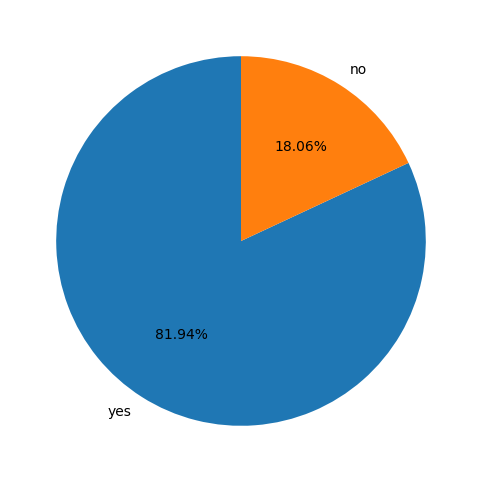

FAVC
yes    20848
no      2021
Name: count, dtype: int64 




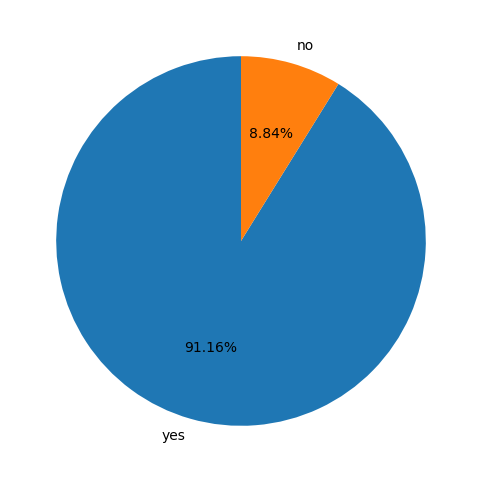

SMOKE
no     22580
yes      289
Name: count, dtype: int64 




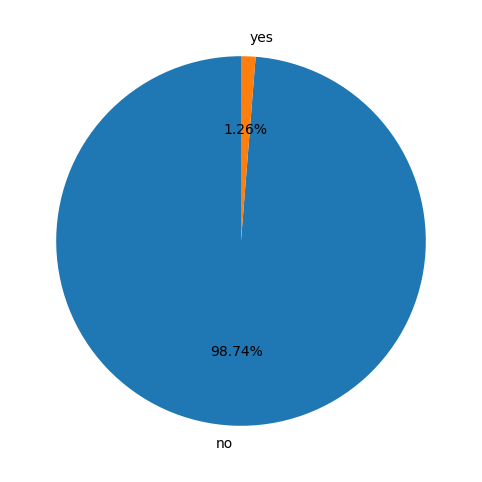

SCC
no     22086
yes      783
Name: count, dtype: int64 




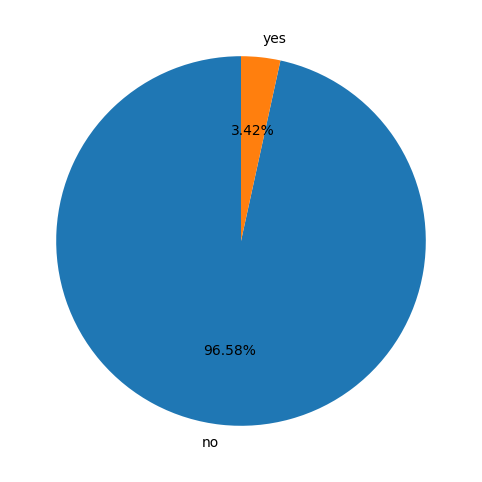

CALC
Sometimes     16467
no             5802
Frequently      599
Always            1
Name: count, dtype: int64 




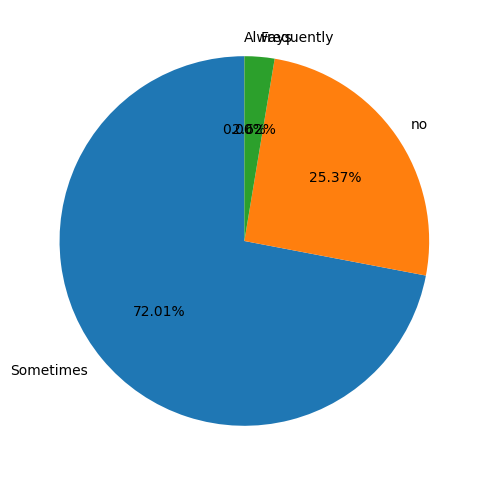

MTRANS
Public_Transportation    18267
Automobile                3991
Walking                    523
Motorbike                   49
Bike                        39
Name: count, dtype: int64 




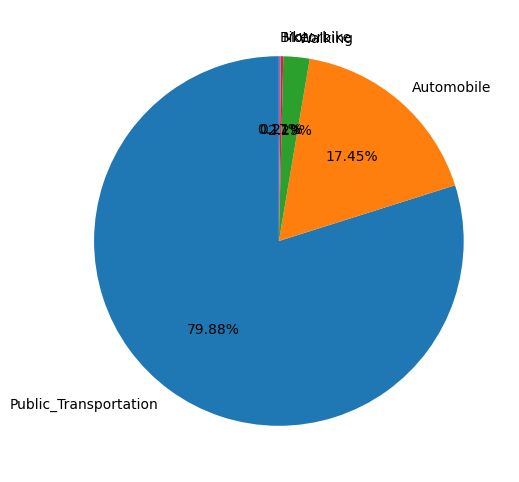

In [15]:
for feature in ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']:
    plt.figure(figsize=(12, 6))
    aggregation = train[feature].value_counts()
    print(aggregation, '\n\n')
    plt.pie(x=aggregation, labels=aggregation.index, autopct='%1.2f%%', startangle=90)
    plt.show()

<a id="7.1"></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">7.1 Figure out how much duplicates in data

In [16]:
train_duplicates_number = train[train.duplicated()]
test_duplicates_number = test[test.duplicated()]
                             
print(len(train_duplicates_number))
print(len(test_duplicates_number))

24
0


##### There are 24 duplicates in train data. Let's remove them!

<a id="7.2"></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">7.2 Remove duplicates from data

In [17]:
train = train.drop_duplicates()

# Check whether all duplicates were removed
train_duplicates = train[train.duplicated()]
print(len(train_duplicates))

0


##### As we see now there is no more duplicates!

<a id="7.3"></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">7.3 One-hot encoding

In [18]:
# Split the train data into X and y
X = train.drop(['NObeyesdad'], axis=1)
X = pd.get_dummies(X, drop_first=True, dtype=int)
test = pd.get_dummies(test, drop_first=True, dtype=int)

X.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0


In [19]:
# Encode target classes
enc = OrdinalEncoder()
train['NObeyesdad'] = enc.fit_transform(train['NObeyesdad'].values.reshape(-1, 1))
y = train.NObeyesdad
y[:10]

0    6.0
1    1.0
2    0.0
3    4.0
4    6.0
5    0.0
6    3.0
7    3.0
8    5.0
9    4.0
Name: NObeyesdad, dtype: float64

<a id='8'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🍟 8 - Display histograms of distribution</span>

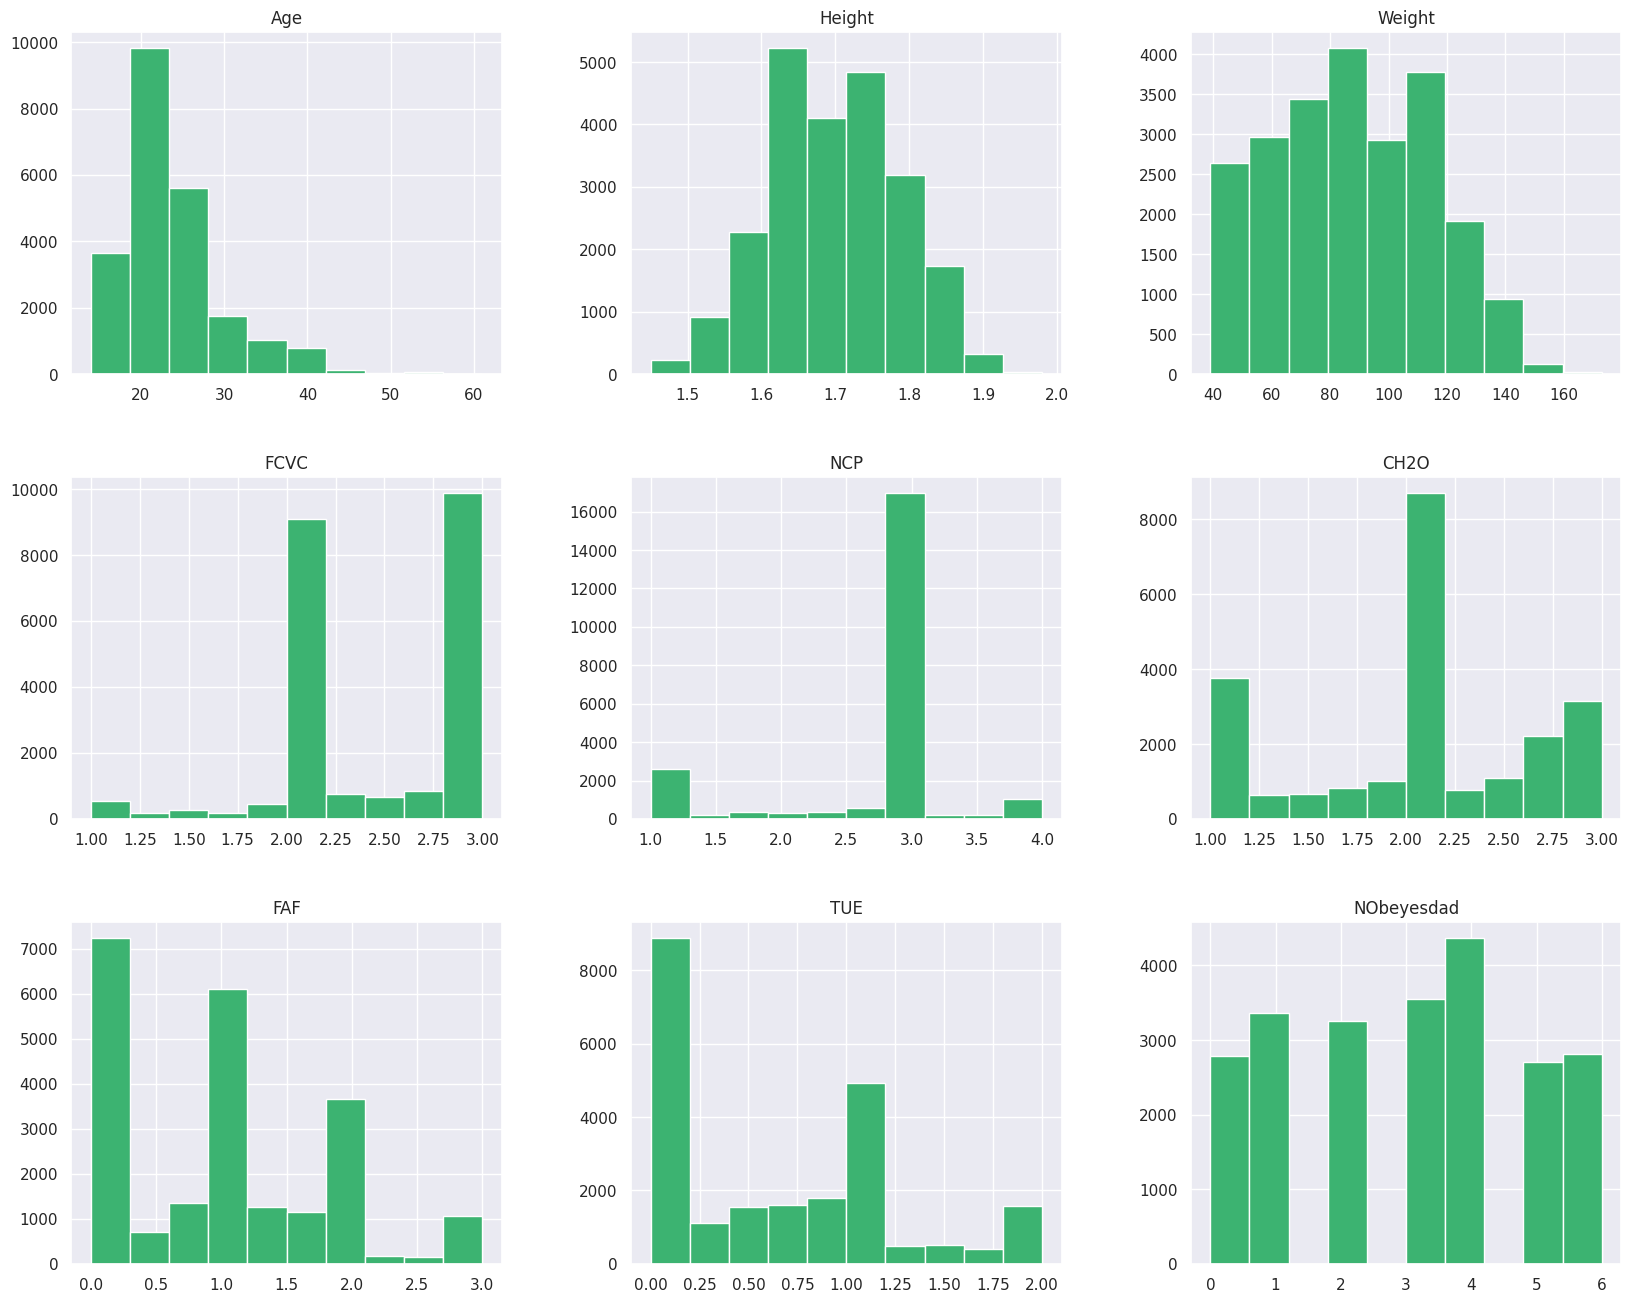

In [20]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='#3cb371');

<a id='9'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🌭 9 - Let's count target of train data</span>

In [21]:
print(f'{y.value_counts()}\n\n')
print(y.value_counts() / y.shape[0])

NObeyesdad
4.0    4370
3.0    3545
1.0    3364
2.0    3261
6.0    2812
0.0    2790
5.0    2703
Name: count, dtype: int64


NObeyesdad
4.0    0.191289
3.0    0.155176
1.0    0.147253
2.0    0.142745
6.0    0.123090
0.0    0.122127
5.0    0.118319
Name: count, dtype: float64


##### Target classes are inbalanced

![](https://t3.ftcdn.net/jpg/01/96/93/78/360_F_196937881_vjymUgqEubdsT1QBzirUuN6GC331DJwy.jpg)

<a id='10'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🌮 10 - Transform the data with logarithm</span>

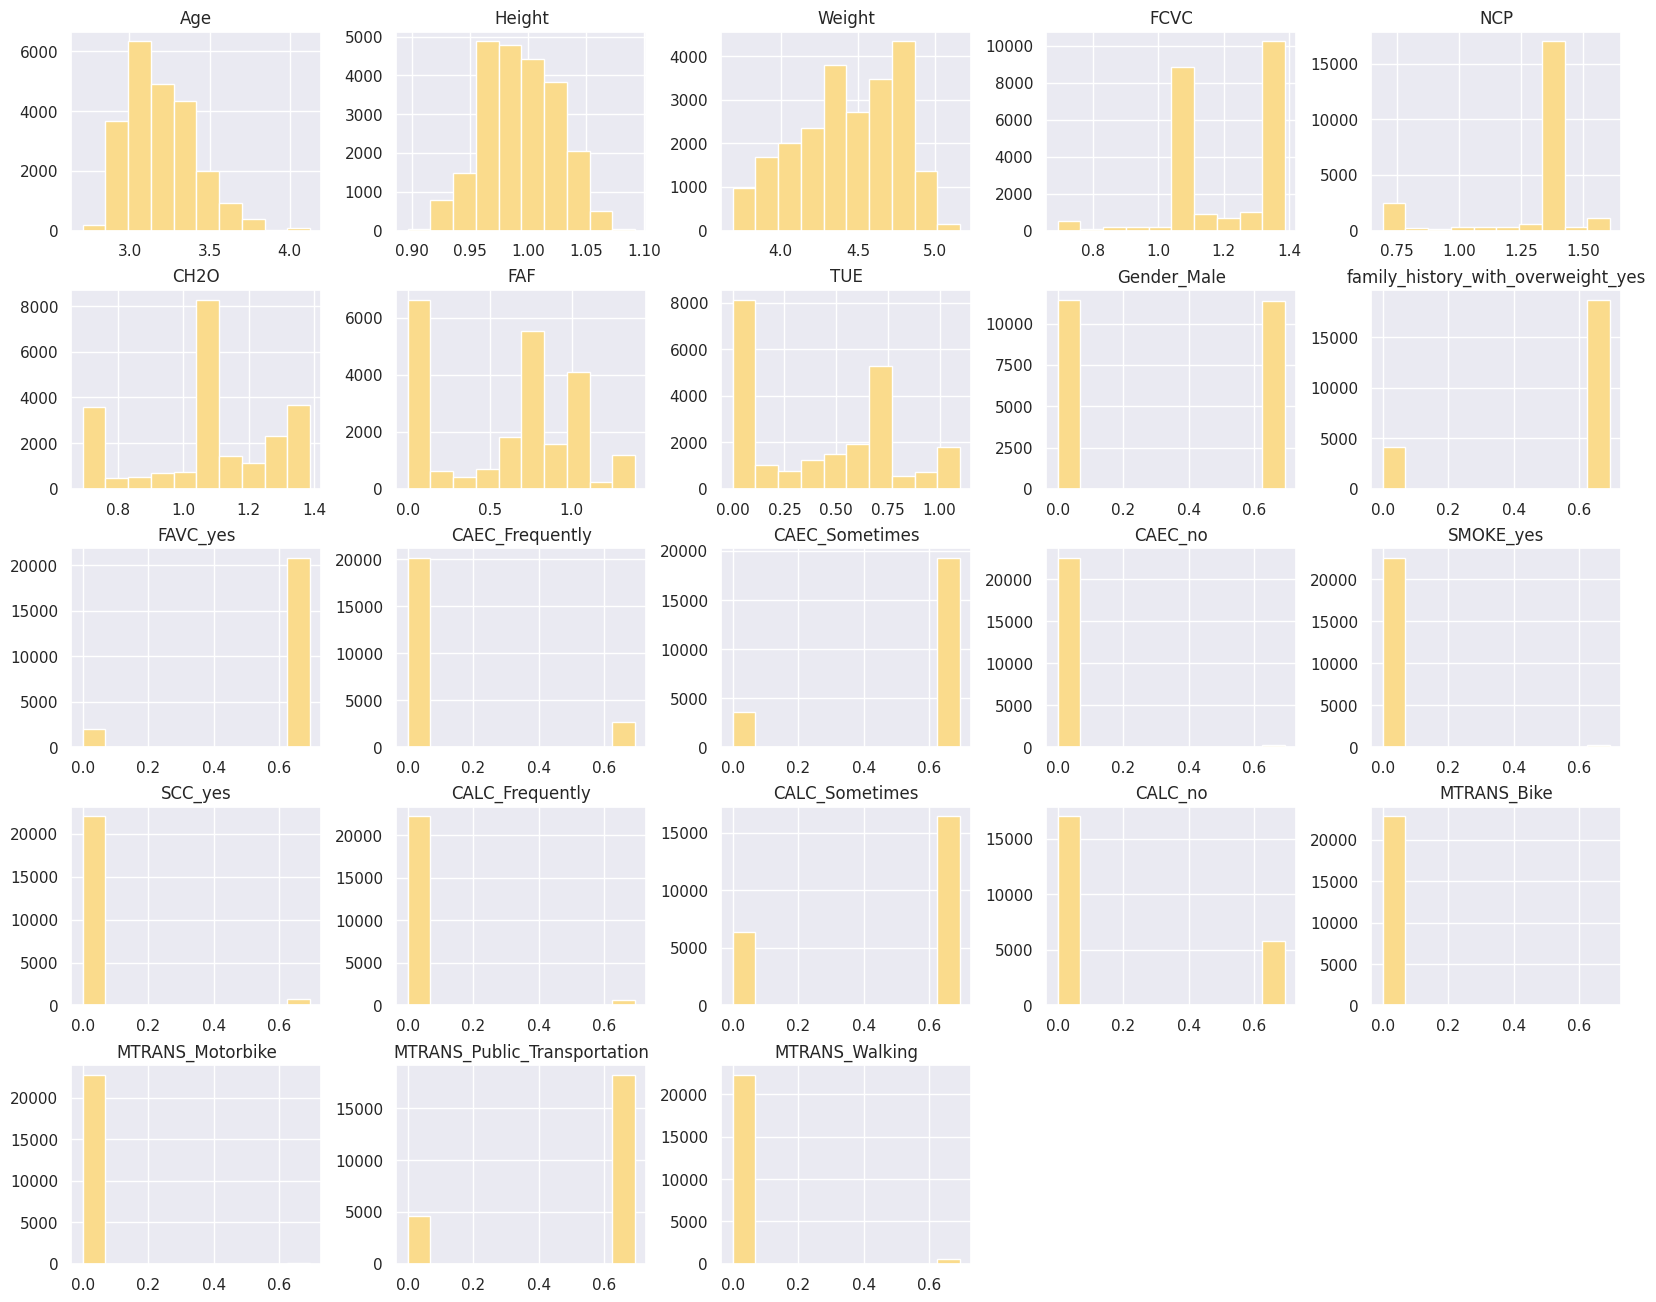

In [22]:
for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log(x + 1))
    
# Transform test data
for column in test.columns.tolist():
    test[column] = test[column].apply(lambda x: np.log(x + 1))
    
X.hist(color='#fadb8c');

<a id='10.1'></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">10.1 - Pie plot of target</span>

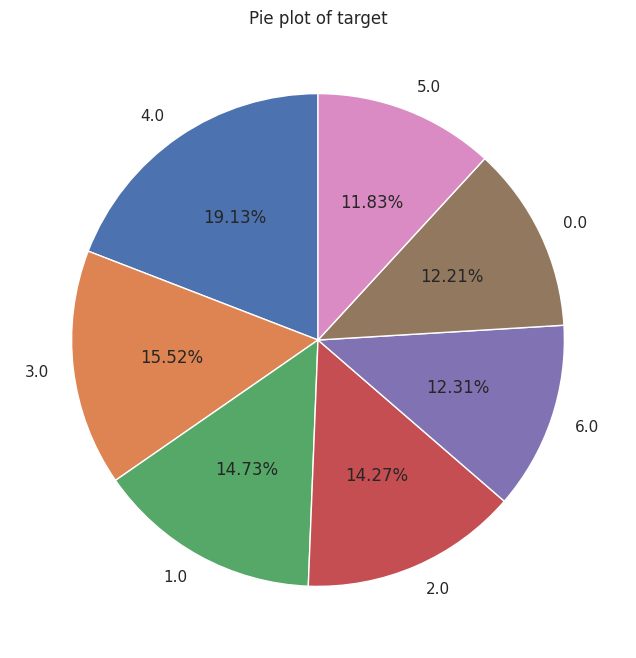

In [23]:
label_counts = y.value_counts()

plt.figure(figsize=(12, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.2f%%', startangle=90)
plt.title('Pie plot of target')
plt.show();

<a id='10.2'></a>
### <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">10.2 Feature importance

CPU times: user 9.78 s, sys: 19.4 ms, total: 9.79 s
Wall time: 9.8 s


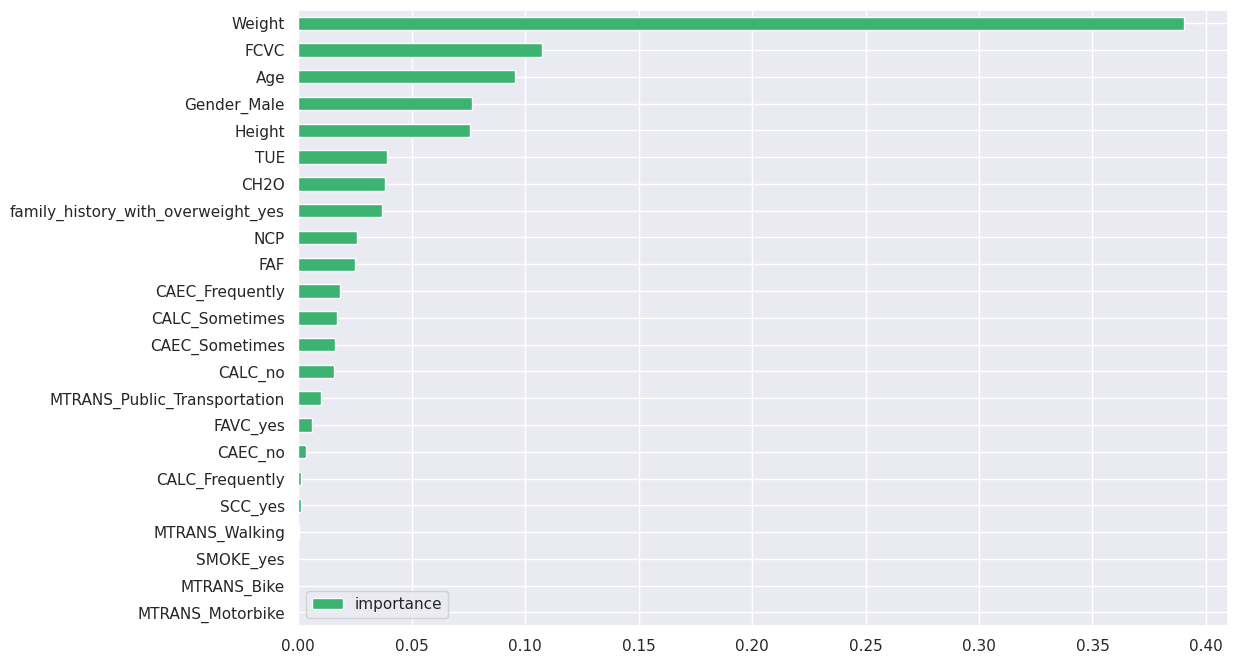

In [24]:
%%time
best_forest = RandomForestClassifier(
    n_estimators=450,
    min_samples_split=2,
    min_samples_leaf=21,
    max_depth=14,
    random_state=27
)
    
best_forest.fit(X, y)
importance = best_forest.feature_importances_
feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')
feature_importance.plot(kind='barh', figsize=(12, 8), color='#3cb371');

<a id='11'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🌯 11 - Build a heat map of correlations</span>

In [25]:
correlation = X.corr()
correlation.style.background_gradient(cmap='crest')

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,FAVC_yes,CAEC_Frequently,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
Age,1.000000,-0.002534,0.364461,0.062079,-0.028140,0.002281,-0.218442,-0.316608,0.066245,0.284378,0.067936,-0.196201,0.211425,-0.048417,0.063371,-0.122787,0.034792,0.068689,-0.083600,0.005529,0.013147,-0.508627,-0.089413
Height,-0.002534,1.000000,0.423230,-0.060001,0.204956,0.201143,0.328911,0.081506,0.623832,0.230706,0.123402,-0.110082,0.128937,-0.076671,0.066362,-0.101524,0.039392,0.070876,-0.087594,0.015755,0.000229,-0.069506,0.040074
Weight,0.364461,0.423230,1.000000,0.197595,0.113102,0.309782,-0.076235,-0.052234,0.166649,0.549612,0.232472,-0.429391,0.448622,-0.074844,0.035682,-0.197761,-0.029353,0.232108,-0.228634,-0.018499,-0.022699,0.015010,-0.091959
FCVC,0.062079,-0.060001,0.197595,1.000000,0.105560,0.088896,-0.079826,-0.113905,-0.286542,0.052629,0.002584,0.012063,0.025459,-0.074883,-0.008097,0.024800,-0.034147,0.144070,-0.136038,-0.015276,0.004088,0.080615,-0.004138
NCP,-0.028140,0.204956,0.113102,0.105560,1.000000,0.090267,0.078031,0.080834,0.049811,0.065960,0.016002,0.030803,0.002827,-0.121216,0.005124,-0.003616,-0.008646,0.117077,-0.117366,0.004776,0.004036,-0.023783,0.034806
CH2O,0.002281,0.201143,0.309782,0.088896,0.090267,1.000000,0.078412,0.010635,0.071760,0.195286,0.036912,-0.155880,0.129290,0.045119,-0.024989,-0.029639,0.004934,0.084251,-0.088748,0.017475,0.003986,0.051277,0.014235
FAF,-0.218442,0.328911,-0.076235,-0.079826,0.078031,0.078412,1.000000,0.004352,0.259635,-0.088204,-0.060755,0.078025,-0.093507,0.030264,0.011966,0.060368,0.048124,-0.122812,0.109026,0.021663,0.000657,-0.033790,0.100450
TUE,-0.316608,0.081506,-0.052234,-0.113905,0.080834,0.010635,0.004352,1.000000,0.030412,0.014485,0.052078,0.019209,-0.000968,-0.062364,-0.016455,-0.017376,0.019906,-0.073039,0.067865,-0.017477,-0.021909,0.173169,0.046750
Gender_Male,0.066245,0.623832,0.166649,-0.286542,0.049811,0.071760,0.259635,0.030412,1.000000,0.097399,0.025739,-0.072019,0.050267,0.025094,0.061051,-0.065596,0.053367,-0.075287,0.057986,0.026633,0.020010,-0.167653,0.060809
family_history_with_overweight_yes,0.284378,0.230706,0.549612,0.052629,0.065960,0.195286,-0.088204,0.014485,0.097399,1.000000,0.158143,-0.292619,0.323084,-0.135798,0.018336,-0.169244,-0.018018,0.007373,-0.001039,-0.024806,-0.012777,-0.059506,-0.086273


##### There is no features with strong correlation

<a id='12'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🥩 12 - Define base models with tuned hyperparameters</span>

## <span style="background-image: url(https://www.kaggle.com/competitions/68479/images/header); color: white; font-size: 30px;">Random Forest</span>

In [26]:
# %%time
# # Searching for best parameters of Random Forest

# random = RandomForestClassifier(random_state=27)

# parameters = {
#     'n_estimators': range(50, 1000, 25),
#     'max_depth': range(2, 30, 2),
#     'min_samples_leaf': range(1, 101, 10),
#     'min_samples_split': range(2, 101, 10)
# }

# random_search = RandomizedSearchCV(estimator=random, param_distributions=parameters, n_iter=10, n_jobs=-1, cv=5, verbose=0, random_state=27)
# random_search.fit(X, y)
# print(random_search.best_params_)

"""
{'n_estimators': 450, 'min_samples_split': 2, 'min_samples_leaf': 21, 'max_depth': 14}
CPU times: user 11.8 s, sys: 467 ms, total: 12.3 s
Wall time: 2min 52s
"""

"\n{'n_estimators': 450, 'min_samples_split': 2, 'min_samples_leaf': 21, 'max_depth': 14}\nCPU times: user 11.8 s, sys: 467 ms, total: 12.3 s\nWall time: 2min 52s\n"

## <span style="background-image: url(https://www.kaggle.com/competitions/68479/images/header); color: white; font-size: 30px;">Cat Boost</span>

In [27]:
%%time
# Searching for best parameters of CatBoost

cat = CatBoostClassifier(learning_rate=0.1, random_state=27)

parameters = {
    'iterations': range(25, 1001, 25),
    'depth': range(2, 17),
    'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001]
}

random_search = RandomizedSearchCV(estimator=cat, param_distributions=parameters, n_iter=1, n_jobs=-1, cv=5, verbose=1, random_state=27)
random_search.fit(X, y)
print(random_search.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0:	learn: 1.9283702	total: 181ms	remaining: 40.5s
1:	learn: 1.9124884	total: 326ms	remaining: 36.4s
2:	learn: 1.8966362	total: 424ms	remaining: 31.3s
3:	learn: 1.8806005	total: 566ms	remaining: 31.3s
4:	learn: 1.8648632	total: 694ms	remaining: 30.5s
5:	learn: 1.8491042	total: 830ms	remaining: 30.3s
6:	learn: 1.8343578	total: 963ms	remaining: 30s
7:	learn: 1.8199291	total: 1.12s	remaining: 30.4s
8:	learn: 1.8053358	total: 1.24s	remaining: 29.8s
9:	learn: 1.7915668	total: 1.36s	remaining: 29.2s
10:	learn: 1.7773711	total: 1.48s	remaining: 28.8s
11:	learn: 1.7637693	total: 1.61s	remaining: 28.6s
12:	learn: 1.7502518	total: 1.76s	remaining: 28.7s
13:	learn: 1.7377417	total: 1.87s	remaining: 28.3s
14:	learn: 1.7248808	total: 2s	remaining: 28s
15:	learn: 1.7126865	total: 2.1s	remaining: 27.5s
16:	learn: 1.7003916	total: 2.23s	remaining: 27.3s
17:	learn: 1.6888617	total: 2.33s	remaining: 26.8s
18:	learn: 1.6769670	total: 2.43s	remaini

## <span style="background-image: url(https://www.kaggle.com/competitions/68479/images/header); color: white; font-size: 30px;">LightGBM</span>

In [28]:
# %%time
# # Searching for best parameters of LightGBM

# lgbm = LGBMClassifier(random_state=27)

# lgbm_parameters = {
#     'n_estimators': range(5, 1001, 10),
#     'num_leaves': range(2, 100, 3),
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': range(2, 100, 2),
# }

# lgbm_random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=lgbm_parameters, n_iter=1, n_jobs=-1, cv=5, verbose=0, random_state=27)
# lgbm_random_search.fit(X, y)
# print(lgbm_random_search.best_params_)

{'num_leaves': 50, 'n_estimators': 995, 'max_depth': 64, 'learning_rate': 0.05}

{'num_leaves': 50, 'n_estimators': 995, 'max_depth': 64, 'learning_rate': 0.05}

## <span style="background-image: url(https://www.kaggle.com/competitions/68479/images/header); color: white; font-size: 30px;">XGBoost</span>

In [29]:
# %%time
# # Searching for best parameters of XGBoost

# xgb = XGBClassifier(random_state=27)

# xgb_parameters = {
#     'n_estimators': range(5, 1001, 10),
#     'learning_rate': [0.001, 0.05, 0.01],
#     'max_depth': range(2, 100, 4),
# }

# xgb_random_search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_parameters, n_iter=10, n_jobs=-1, cv=5, verbose=2, random_state=27)
# xgb_random_search.fit(X, y)
# print(f'Best params: {xgb_random_search.best_params_}')

"""
Best params: {'n_estimators': 685, 'max_depth': 50, 'learning_rate': 0.05}
CPU times: user 33min 36s, sys: 19.6 s, total: 33min 55s
Wall time: 33min 58s
"""

"\nBest params: {'n_estimators': 685, 'max_depth': 50, 'learning_rate': 0.05}\nCPU times: user 33min 36s, sys: 19.6 s, total: 33min 55s\nWall time: 33min 58s\n"

In [30]:
base_models = [
    ('catboost', CatBoostClassifier(
        iterations=225,
        learning_rate=0.005,
        depth=7,
        random_state=27
    )),
    ('xgboost', XGBClassifier(
        n_estimators=685,
        learning_rate=0.05,
        max_depth=50,
        random_state=27
    )),
    ('lightgbm', LGBMClassifier(
        n_estimators=995,
        num_leaves=50,
        learning_rate=0.05,
        max_depth=64,
        random_state=27,
    )),
    ('random_forest', RandomForestClassifier(
        n_estimators=450,
        min_samples_split=2,
        min_samples_leaf=21,
        max_depth=14,
        random_state=27,
    )),
]

<a id='13'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🍩 13 - Defining the meta-model with tuned hyperparameters</span>

In [31]:
meta_model = XGBClassifier(
    n_estimators=685,
    learning_rate=0.05,
    max_depth=50,
    random_state=27
)

<a id='14'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🥗 14 - Creating and fitting the stacking model

![](https://qph.cf2.quoracdn.net/main-qimg-7f38ef83c49e23f246b792bf45f90ec1-lq)

In [32]:
%%time
X_train, X_val, y_val, y_val = train_test_split(X, y, test_size=0.2, random_state=27)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X, y)

0:	learn: 1.9282645	total: 37ms	remaining: 8.28s
1:	learn: 1.9122047	total: 74.4ms	remaining: 8.3s
2:	learn: 1.8949096	total: 109ms	remaining: 8.06s
3:	learn: 1.8787111	total: 142ms	remaining: 7.86s
4:	learn: 1.8627447	total: 178ms	remaining: 7.81s
5:	learn: 1.8469243	total: 209ms	remaining: 7.64s
6:	learn: 1.8318337	total: 241ms	remaining: 7.52s
7:	learn: 1.8170233	total: 273ms	remaining: 7.41s
8:	learn: 1.8027076	total: 304ms	remaining: 7.29s
9:	learn: 1.7887375	total: 335ms	remaining: 7.21s
10:	learn: 1.7744343	total: 367ms	remaining: 7.14s
11:	learn: 1.7603870	total: 400ms	remaining: 7.1s
12:	learn: 1.7468788	total: 433ms	remaining: 7.06s
13:	learn: 1.7338764	total: 467ms	remaining: 7.04s
14:	learn: 1.7208456	total: 504ms	remaining: 7.06s
15:	learn: 1.7082163	total: 537ms	remaining: 7.01s
16:	learn: 1.6960248	total: 571ms	remaining: 6.98s
17:	learn: 1.6844727	total: 603ms	remaining: 6.93s
18:	learn: 1.6727162	total: 636ms	remaining: 6.89s
19:	learn: 1.6603578	total: 670ms	remaining

StackingClassifier(estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x797db5c385b0>),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gr...
                                                 feature_types=None, gamma=None,
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.05,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=50, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=685, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=27, ...))

<a id='15'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🍺 15 - Predict the validation set and calculate accuracy score</span>

In [33]:
y_pred_val = stacking_model.predict(X_val)

accuracy_val = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy Score: {accuracy_val:.8f}")

Validation Accuracy Score: 0.98533596


<a id='16'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🫐 16 - Predict the test data</span>

In [34]:
y_pred_test = stacking_model.predict(test)
y_pred_test[:10]

array([3., 5., 4., 2., 4., 0., 0., 1., 6., 1.])

In [35]:
result = np.ravel(enc.inverse_transform(y_pred_test.reshape(-1, 1)))
result[:10]

array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III',
       'Obesity_Type_I', 'Obesity_Type_III', 'Insufficient_Weight',
       'Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_II',
       'Normal_Weight'], dtype=object)

<a id='17'></a>
# <span style="color: #3cb371; border-bottom: 6px solid #03adfc; background-color: #fadb8c;">🍉 17 - Build DataFrame and make submission</span>

In [36]:
submission = pd.DataFrame({
    'id': submission_id,
    'NObeyesdad': result
})

submission.to_csv('Kapturov_S4E2_submission.csv', index=False)
submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


# <span style="color: #03adfc">🏋️‍♀️😀 Hope You are feel Yourself great!</span>